## Goal: estimate satisfaction function of a formula from instances of its satisfaction on individual runs at discrete parameter values

We use Gaussian Process Classification to estimate the satisfaction function.
Problem: the exact computation of the posterior probability is not possible --> use approximation from **Expectation Propagation (EP)** approach (high accuracy + computational efficiency) 

EP computes a Gaussian approximation to probabilistic models of the form
$ p(x|y) = p_0(x) \prod_i t_i (y_i,x_i)$   

$p_0(x)$ is a multivariate Gaussian distribution coupling all $x_i$ variables (*site variables*), $t_i$ can be general univariate distributions. Those models are calles *latent Gaussian models*: p0 represents prior distribution, with ti representing non-Gaussian observation likelihoods.  
EP approximation: likelihood terms replaced by univariate Gaussian terms $ q(x|y) = p_0(x) \prod_i \tilde{t}_i (y_i,x_i) $  



In [61]:
import numpy as np
import numpy.matlib

import math

from scipy.stats import norm
from scipy.special import erf 

import matplotlib.pyplot as plt
%matplotlib inline



# Kernel

We place a GP prior over the latent function $f(x)$ and then squash it to obtain the prior on $\pi(x) = p(y=1|x) = \sigma(f(x))$.  
We use the squared exponential covariance function $k(x,x')= \sigma^2 exp(- \frac{(x-x')^2}{2\lambda^2}) $.  
Squash it with: probit transformation (cdf of normal distribution, $\Phi(z) = \int^z_{-\inf} \mathcal{N}(x|0,1)dx$).

We don't observe values of f itself, only inputs X and class labels y. We are only interested in $\pi$.

In [62]:
def kernel_rbf(X1, X2, param):
    """
    Squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        param: Kernel parameters (2)

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return param[1] ** 2 * np.exp(-0.5 / param[0] ** 2 * sqdist)


# default hyperparameters of kernel (could optimize it, but here just default values)
params = [1, 1]

## Inference

2 steps:  
- compute distribution of latent variable corresponding to a test case: $p(f_*|X,y,x_*) = \int p(f_*|X,x_*,f) p(f|X,y) df$, where $p(f|X,y) = p(y|f)p(f|X)/p(y|X)$ is the posterior over the latent variables      

   
     
- use this distribution over latent $f_*$ to produce probabilistic prediction: $\overline{x}_* = p(y_*=1|X,y,x_*) = \int \sigma(f_*)p(f_*|X,y,x_*)df$   


Non-Gaussian likelihood makes integral intractable $\rightarrow$ approximate with Gaussian posterior $\Rightarrow$ Expectation Propagation algorithm

## Expectation Propagation

Posterior given by Bayes rule as product of normalization term, prior and likelihood: $p(f|X,y) = \frac{1}{Z} p(f|X) \prod p(y_i|f_i)$  
Prior $p(f|X)$ is Gaussian  
Likelihood factorizes over training cases  
Normalization term = marginal likelihood: $Z = p(y|X) = \int p(f|X) \prod p(y_i|f_i) df$  

Probit likelihood for binary classification: $p(y_i|f_i) = \Phi(f_iy_i)$  
$\rightarrow$ approximate by local likelihood approximation (unnormalized Gaussian function in latent variable $f_i$): $p(y_i|f_i) \approx t_i ( f_i|\tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \tilde{Z}_i \mathcal{N}(f_i|\tilde{\mu}_i,\tilde{\sigma}_i^2)$  

Product of independent local likelihoods $t_i$: $\prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\tilde{\mu},\tilde{\Sigma}) \prod \tilde{Z}_i$, where $\tilde{\mu}$ is vector of $\tilde{\mu}_i$ and $\tilde{\Sigma}$ is diagonal with $\tilde{\Sigma}_{ii} = \tilde{\sigma}^2_i$.  

Approximate posterior $p(f|X,y)$ by: $q(f|X,y) = \frac{1}{Z_{EP}} p(f|X) \prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)$ [3.53] with $Z_{EP}=q(y|X)$ (approximation to normalizing term Z from previous eq.), $\mu=\Sigma\tilde{\Sigma}^{-1}\tilde{\mu}$ and $\Sigma=(K^{-1}+\tilde{\Sigma}^{-1})^{-1}$  

### How do we choose parameters of local approximating distributions $t_i$?  
Update individual $t_i$ approximations sequentially. Iterate these 4 steps until convergence:  
1. start from some current approximate posterior, from which we leave out current $t_i$ $\rightarrow$ marginal cavity distribution  
2. Combine cavity distribution with exact likelihood $p(y_i|f_i)$ to get desired (non-Gaussian) marginal  
3. Choose Gaussian approximation to marginal  
4. Compute the $t_i$ which makes posterior have the desired marginal from step 3   

Approximate posterior for $f_i$ contains 3 kinds of terms:  
1. Prior $p(f|X)$  
2. Local approximate likelihoods $t_j$ for all cases $j\neq i$  
3. Exact likelihood for case i, $p(y_i|f_i) = \Phi(y_if_i)$   

Goal: combine these sources of information and choose parameters of $t_i$ such that the marginal posterior is as accurate as possible. 

1. Combine prior and local likelihood approximations into cavity distribution: $q_{-i}(f_i) \propto \int p(f|X) \prod_{j\neq i} t_j (f_j|\tilde{Z}_j, \tilde{\mu}_j, \tilde{\sigma}_j^2) df_j$  
Either by explicitly multiplying out the terms, or by removing approximate likelihood i from the approximate posterior in 3.53.
2. Combine this with exact likelihood for case i. 

### 1) Initialization, perform statistical model checking

- Set parameters for smoothed model checking  
- Invent parameters: assume 10 trajectories per input point and statistically estimate outputs (number of runs satisfying property / total number of runs)


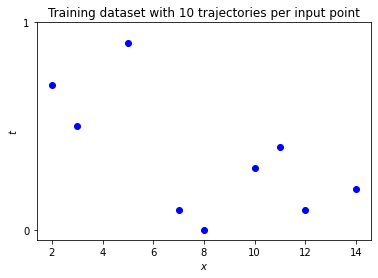

Actual data (number of runs satisfying property):  [[7. 5. 9. 1. 0. 3. 4. 1. 2.]]


In [63]:
# parameters for smoothed model checking
simulation_runs = scale = 10  # number of trajectories per input point
paramValueSet = np.array([2,3,5,7,8,10,11,12,14]).reshape(-1,1) # uncertain input parameter that is varied = population size
datapoints = len(paramValueSet)  # number of input points
paramValueOutputs = np.array([0.7,0.5,0.9,0.1,0,0.3,0.4,0.1,0.2]).reshape(-1,1) # statistical outputs of satisfaction 
data = trainingSet = [paramValueSet, paramValueOutputs] # set as training set for GP

# correction for covariance matrix calculation
correction = 1e-4

# plot training data
plt.scatter(paramValueSet, paramValueOutputs, marker='o', c='blue')
plt.title('Training dataset with 10 trajectories per input point')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.show()

print("Actual data (number of runs satisfying property): ", (paramValueOutputs * scale).reshape(1,-1))

### 2) Perform smoothed model checking (SMC 65)

getAnalyticApproximation(data, parameters, options)  
-> optimize hyperparameters for rbf kernel or take default ones  
-> doTraining = probit gp regression  
   -> expectationPropagation
   
then return performSmoothedModelChecking(approx, parameters, options)

### Helper functions for EP

! Attention: computation of cholesky(A) may fail when A is not PD (for large amplitudes) --> that's why I added another +I for computational stability  


$\tilde{v} = ... $

In [71]:
def marginal_moments(Term, gauss_LC, gauss_LC_t):
    """
    Computes marginal moments
    
    Args:
        Term: v_tilde, tau_tilde (datapoints, 2)
        gauss_LC:
        gauss_LC_t: 
        
    Returns:
        logZappx
        gauss_m (datapoints,1)
        gauss_diagV (datapoints,1)
    """
    
    # A = LC' * (tau_tilde * gauss_LC) + I 
    # Q: Why add 1 as correction? Not too much? 
    tmp = np.multiply(Term[:,1], gauss_LC)
    A = np.matmul(gauss_LC_t, tmp) + np.eye(datapoints)

    gauss_L = np.linalg.cholesky(A + np.eye(datapoints)).T  
#    gauss_L = np.linalg.cholesky(A).T  

    # W = L\LC'
    gauss_W = np.linalg.solve(gauss_L, gauss_LC_t)
    gauss_diagV = np.diagonal(np.matmul(gauss_W.T, gauss_W)).reshape(-1,1)
    
    # m = W'*(W * v_tilde)
    tmp = np.matmul(gauss_W, Term[:,0])
    gauss_m = np.matmul(gauss_W.T, tmp).reshape(-1,1)

    # logdet = -2*sum(log(diag(L))) + 2*sum(log(diag(LC)))
    logdet = -2*np.sum(np.log(np.diagonal(gauss_L))) # + 2*np.sum(np.log(np.diag(gauss_LC))) (das ist schon logdet_LC)
    logdet += logdet_LC

    # logZappx = 1/2(m' * v_tilde + logdet)
    logZappx = 0.5 * (np.dot(gauss_m.T, Term[:,0]) + logdet)

    return logZappx, gauss_m, gauss_diagV

In [65]:
def gausshermite(nodes):
    """
    Gauss-Hermite 
    https://indico.frib.msu.edu/event/15/attachments/40/157/Gaussian_Quadrature_Numerical_Recipes.pdf
    
    Args:
        nodes: number of Gauss-Hermite nodes (1)
        
    Returns:
        x0: abscissas
        w0: weights
    """

    x0 = np.zeros((nodes, 1))
    w0 = np.zeros((nodes, 1))
    m = int((nodes+1)/2)
    z,pp,p1,p2,p3 = 0,0,0,0,0
    
    for i in range(m):
        if i==0:
            z = np.sqrt(2*nodes+1) - 1.85575 * ((2*nodes+1)**(-0.166667))
        elif i==1:
            z = z - 1.14 * (nodes**0.426) / z
        elif i==2:
            z = 1.86 * z - 0.86 * x0[0]
        elif i==3:
            z = 1.91 * z - 0.91 * x0[1]
        else:
            z = 2.0 * z - x0[i - 2]

        for its in range(10):
            p1 = 1/np.sqrt(np.sqrt(np.pi))
            p2 = 0
            for j in range(1,nodes+1):
                p3=p2
                p2=p1
                a = z*np.sqrt(2/j)*p2
                b = np.sqrt((j-1)/j)*p3
                p1=a-b
            pp=np.sqrt(2*nodes)*p2
            z1=z
            z=z1-p1/pp
            if np.abs(z-z1)<2.2204e-16:
                break

        x0[i] = z
        x0[nodes-1-i] = -z
        w0[i] = 2/(pp*pp)
        w0[nodes-1-i] = w0[i]

    w0 = np.divide(w0, np.sqrt(np.pi))
    x0 = np.multiply(x0, np.sqrt(2))
    x0 = np.sort(x0, axis=None).reshape(-1,1)
    
    return x0, w0


def GaussHermiteNQ(FuncPar_p, FuncPar_q, m, v, xGH, logwGH):
    """
    Gauss-Hermite numerical quadrature for Gaussian integration and moment computation
    
    Args:
        FuncPar_p: number of runs satisfying property for each parameter value (input) (datapoints,1)
        FuncPar_q: number of runs not satisfying property (datapoints,1)
        m: cavity mean mu_-i
        v: cavity variance sigma^2_-i
        xGH: abscissas (Gauss-Hermite)
        logwGH: weights (Gauss-Hermite)
        
    Returns:
        logZ
        Cumul: mu_hat, ... (datapoints,2)
    """
    
    Nnodes = len(xGH)
    stdv = np.sqrt(v).reshape(-1,1)

    Y = np.matmul(stdv, xGH.reshape(1,-1)) + numpy.matlib.repmat(m, 1, Nnodes)
        
    G = np.array(logprobitpow(Y, FuncPar_p, FuncPar_q) + numpy.matlib.repmat(logwGH.T, datapoints, 1))
    
    # maximum of each row (input value) over all 96 nodes
    maxG = G.max(axis=1).reshape(-1,1)
    # subtract maximum value
    G = G - np.matlib.repmat(maxG, 1, 96)
    # exponential value
    expG = np.exp(G)
    # denominator (row sum)
    denominator = expG.sum(axis=1).reshape(-1,1)
    logdenominator = np.log(denominator)
    logZ = maxG + logdenominator
    
    Cumul = np.zeros((len(FuncPar_p), 2))


    # deltam = stdv * (expG * xGH) / denominator
    deltam = np.divide(np.multiply(stdv, np.matmul(expG, xGH)), denominator)

    # mu_hat = mu_-i + deltam    
    Cumul[:,0] = (m + deltam).reshape(-1)
    
    xGH2 = xGH**2
    deltam2 = deltam**2

    # sigma^2_hat = 
    Cumul[:,1] = (np.divide(np.multiply(v, np.matmul(expG, xGH2)), denominator) - deltam2).reshape(-1)
        
    return logZ, Cumul

In [66]:
def cavities(gauss_diagV, gauss_m, Term):
    """
    Compute cavities
    
    Args:
        gauss_diagV:
        gauss_m:
        Term: v_tilde, tau_tilde (datapoints,2)
        
    Returns:
        cav_m: cavity mean 
        cav_diagV: cavity variance
    """
    
    # s = 1 / (1 + tau_tilde * diagV)
    s = np.divide(1, (1 + np.multiply(-Term[:,1].reshape(-1,1), gauss_diagV)))

    # cav_diagV = s * diagV
    cav_diagV = np.multiply(s, gauss_diagV)
    
    # m = s * (m + v_tilde * diagV)
    cav_m = np.multiply(s, (gauss_m + np.multiply(-Term[:,0].reshape(-1,1), gauss_diagV)))
    
    return cav_m, cav_diagV
        

3.59  
$\tilde{v} = \hat{\sigma}_i^{-2} \hat{\mu}_i - \sigma_{-i}^{-2} \mu_{-i}$

$\tilde{\tau} = 1 / \hat{\sigma}_i^2 - 1 / \sigma_{-i}^2$

In [67]:
def ep_update(cav_diagV, cav_m, Term, eps_damp, gauss_LikPar_p,
              gauss_LikPar_q, gauss_xGauss, gauss_logwGauss):
    """
    Update site parameters
    
    Args:
        cav_diagV: cavity variance sigma^2_-i
        cav_m: cavity mean mu_-i
        Term: v_tilde, tau_tilde (datapoints,2)
        eps_damp: 0.5
        gauss_LikPar_p: number of runs satisfying property for each parameter (datapoints,1)
        gauss_LikPar_q: number of runs not satisfying property (datapoints,1)
        gauss_xGauss: abscissas of Gauss-Hermite
        gauss_logwGauss: weights of Gauss-Hermite
        
    Returns:
        TermNew: updated v_tilde, tau_tilde (datapoints,2)
        logZterms:
        logZ:
    """
    
    # Cumul = [mu_hat, sigma^2_hat]
    logZ, Cumul = GaussHermiteNQ(gauss_LikPar_p, gauss_LikPar_q, cav_m, cav_diagV, gauss_xGauss, gauss_logwGauss)
        
    m2 = cav_m**2
    logV = np.log(cav_diagV)
    
    cumul1 = (Cumul[:,0]**2).reshape(-1,1)
    cumul2 = (np.log(Cumul[:,1])).reshape(-1,1)    
    
    logZterms = logZ + np.multiply(np.divide(m2, cav_diagV) + logV - 
                                   (np.divide(cumul1, Cumul[:,1].reshape(-1,1)) + cumul2), 1/2)
        
    c1 = np.divide(Cumul[:,0].reshape(-1,1), Cumul[:,1].reshape(-1,1)) - (np.divide(cav_m, cav_diagV))
    c2 = np.divide(np.ones((datapoints,1)), Cumul[:,1].reshape(-1,1)) - (np.divide(np.ones((datapoints,1)), cav_diagV))
        
    TermNew = np.concatenate((c1, c2), axis=1)

    TermNew = np.multiply(Term, (1 - eps_damp)) + np.multiply(TermNew, eps_damp)

    return TermNew, logZterms, logZ

Appendix 3.9  

$\Phi(f(x)) = \frac{1}{2} (1 + erf( x / \sqrt{2} )) $

In [68]:
def logprobitpow(X, p, q):
    """
    Compute ncdflogbc for matrices
    
    Args:
        X: matrix (datapoints,96)
        p:
        q:
        
    Returns:
        Za+Zb:
    """
    
    threshold = -np.sqrt(2)*5
    Za = []
    y = []
    j = 0
    for x in X:
        y.append([])
        #print(x)
        for i in x:
            if i >= 0:
                #print("1")
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                #print("2")
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                #print("3")
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1
    #print(y)
    Za = np.multiply(y, numpy.matlib.repmat(p.reshape(-1,1), 1, 96))

    Zb = []
    y = []
    j = 0
    for x in (-X):
        y.append([])
        #print(x)
        for i in x:
            #print(i)
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1

    Zb = np.multiply(y, numpy.matlib.repmat(q.reshape(-1,1), 1, 96))
    return Za + Zb
    

### Expectation Propagation

In [69]:
# Redefine data, such that we have everything here at one place

simulation_runs = scale = 5  # number of trajectories per input point
paramValueSet = np.linspace(0.5, 5, 20).reshape(-1,1) # uncertain input parameter that is varied = population size
datapoints = len(paramValueSet)  # number of input points
paramValueOutputs = np.array([1,1,0.8,1,1,1,1,0.6,0.6,0.6,0.8,0,0.8,0.2,0.6,0,0.4,0.4,0,0.2]).reshape(-1,1) # statistical outputs of satisfaction 
data = trainingSet = [paramValueSet, paramValueOutputs] # set as training set for GP


In [72]:
# initialization (all 0)
gauss_C = kernel_rbf(paramValueSet, paramValueSet, params) + correction * np.eye(datapoints) # covariance training set

gauss_LC_t = np.linalg.cholesky(gauss_C + 1e-4 * np.eye(datapoints))  # cholesky decomposition, returns A=U'*U
gauss_LC = gauss_LC_t.T  # transpose L' (or other way round?)
gauss_LC_diag = np.diagonal(gauss_LC).reshape(-1,1)

logdet_LC = 2*np.sum(np.log(gauss_LC_diag))
logZprior = 0.5*logdet_LC

logZterms = np.zeros(datapoints).reshape(-1,1)
logZloo = np.zeros(datapoints).reshape(-1,1)
Term = np.zeros((datapoints, 2))  # Term[:,0] = v tilde, Term[:,1] = tau tilde

# compute marginal moments
logZappx, gauss_m, gauss_diagV = marginal_moments(Term, gauss_LC, gauss_LC_t)

# related to likelihood approximation
# true observation values (number of trajectories satisfying property)
gauss_LikPar_p = paramValueOutputs * scale
gauss_LikPar_q = scale - gauss_LikPar_p 

# gauss hermite: quadrature to approximate values of integral, returns abscissas (x) and weights (w) of
# n-point Gauss-Hermite quadrature formula
nodes = 96
gauss_xGauss, gauss_wGauss = gausshermite(nodes)
gauss_logwGauss = np.log(gauss_wGauss)

# parameters for loop initialization
MaxIter=1000
tol=1e-6
logZold=0
logZ = 2*tol
steps=0
logZappx=0
eps_damp=0.5

while (np.abs(logZ-logZold)>tol) and (steps<MaxIter):
#while steps==0:
    steps += 1
    logZold = logZ
    
    cav_m, cav_diagV = cavities(gauss_diagV, gauss_m, Term)
    
    Term, logZterms, logZloo = ep_update(cav_diagV, cav_m, Term, eps_damp, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss)
    
    logZappx, gauss_m, gauss_diagV = marginal_moments(Term, gauss_LC, gauss_LC_t)
    
    logZ = logZterms.sum() + logZappx
    
    print("Iteration ", steps)
    

logZ = logZ - logZprior
gauss_logZloo = logZloo.sum()
gauss_logZappx = logZappx
gauss_logZterms = logZterms
gauss_logZ = logZ
gauss_Term = Term

Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27


### Finish Training  

$\tilde{\mu} = 1/\tilde{S} * \tilde{v} $

In [73]:
v_tilde = gauss_Term[:,0].reshape(-1,1)
tau_tilde = gauss_Term[:,1].reshape(-1,1)

diagSigma_tilde = 1/tau_tilde

mu_tilde = np.multiply(v_tilde, diagSigma_tilde)

Sigma_tilde = np.zeros((datapoints, datapoints))
np.fill_diagonal(Sigma_tilde, diagSigma_tilde)

invC = np.linalg.solve((gauss_C + Sigma_tilde), np.eye(len(mu_tilde)))

#print(invC)

### get GP Posterior


In [74]:
# define test set for which posterior is derived
#testpoints = X_s = np.linspace(0, 20, 100).reshape(-1,1)
testpoints = X_s = np.linspace(0, 5, 100).reshape(-1,1)


# calculate variances of testset and covariances of test & training set (apply kernel)
kss = kernel_rbf(testpoints, testpoints, params) #+ correction * np.eye(testpoints) 
ks = kernel_rbf(testpoints, paramValueSet, params) #+ correction * np.eye(datapoints)


# mean function mu
fs = np.matmul(np.matmul(ks, invC), mu_tilde)
#fs = ks.T.dot(np.linalg.solve(invC.T, np.linalg.solve(invC, mu_tilde)))

# covariance function of posterior -> here only diagonal (variance)
vfs = (np.diagonal(kss) - (np.diagonal(np.matmul(np.matmul(ks, invC), ks.T)))).reshape(-1,1)


### Probit Regression Posterior
Compute confidence bounds and plot results

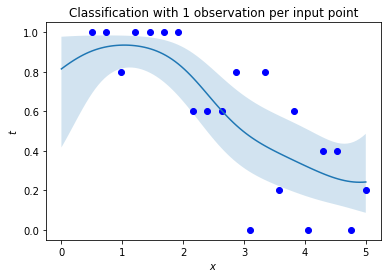

In [75]:
# function to compute probit values
def standardNormalCDF(x):
    return 1/2 + 1/2 * erf(x * (1/np.sqrt(2)))

# Q: What is this for? Why added to probabilities?
cached_denominator = (1 / np.sqrt(1 + vfs)).reshape(-1,1)


# get probabilities with probit function
probabilities = standardNormalCDF(fs * cached_denominator)


# compute confidence bounds
lowerbound = standardNormalCDF((fs - 1.96 * np.sqrt(vfs).reshape(-1,1)) *
                              cached_denominator)
upperbound = standardNormalCDF((fs + 1.96 * np.sqrt(vfs).reshape(-1,1)) *
                              cached_denominator)

# plot data
plt.plot(testpoints, probabilities, lw=1.5, ls='-')
plt.fill_between(testpoints.ravel(), lowerbound.ravel(), upperbound.ravel(), alpha=0.2)
plt.scatter(paramValueSet, paramValueOutputs, marker='o', c='blue')
plt.title('Classification with 1 observation per input point')
plt.xlabel('$x$')
plt.ylabel('$t$')
#plt.yticks([0, 1])
plt.show()